# PUBG绝地求生聚类分析[四排]

<p>运用到的方法：Kmeans, AGG, DBSCAN

## 1、全特征聚类

In [1]:
import pandas as pd
import numpy as np
#读取数据集sampleSquad.csv
data = pd.read_csv('sampleSquad_V2.csv')
data.shape

(50000, 32)

In [2]:
#挑选出用于聚类的特征
data_cluster = data.drop(columns=['winPlacePerc','matchDuration'])
column = data_cluster.columns
data_cluster.head()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,kills,killStreaks,longestKill,...,kill_rate,playersInGroup,weaponsPerDistance,healsPerDistance,killsPerDistance,distance_over_weapons,distance_over_heals,distance_over_kills,healthitems,skill
0,0.00,2,43.845,1.11,0.00,4,24.42,1.11,1.11,94.530,...,0.500,4,0.001372,0.001383,0.000384,729.082500,729.0825,2627.324324,6,1.11
1,0.00,0,0.000,0.00,0.00,0,83.20,0.00,0.00,0.000,...,0.000,3,0.020629,0.000000,0.000000,48.475000,0.0000,0.000000,0,0.00
2,0.00,4,230.672,2.08,2.08,0,15.60,2.08,1.04,55.760,...,0.500,3,0.001660,0.000000,0.000863,602.250000,0.0000,1158.173077,4,3.12
3,1.07,1,486.101,4.28,0.00,5,10.70,3.21,2.14,7.759,...,0.375,3,0.004152,0.002595,0.001666,240.875000,385.4000,600.311526,6,2.14
4,0.00,0,0.000,0.00,0.00,0,83.93,0.00,0.00,0.000,...,0.000,1,0.019023,0.000000,0.000000,52.566667,0.0000,0.000000,0,0.00


In [3]:
# Z-score标准化
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
data_input = ss.fit_transform(data_cluster)
data_input

array([[-0.48876395,  0.30525328, -0.61830816, ...,  1.29031066,
         0.62732224,  0.12249579],
       [-0.48876395, -0.78528754, -0.84598281, ..., -0.53277518,
        -0.76746073, -0.73092018],
       [-0.48876395,  1.3957941 ,  0.35183148, ...,  0.27087472,
         0.16239458,  1.66787066],
       ...,
       [-0.48876395, -0.78528754,  0.01735823, ...,  1.45570871,
        -0.5349969 ,  0.83751998],
       [-0.48876395, -0.24001713,  1.0821507 , ..., -0.2232174 ,
        -0.5349969 ,  1.64480536],
       [-0.48876395, -0.78528754, -0.62046314, ..., -0.53277518,
        -0.76746073, -0.73092018]])

### K-means聚类

In [5]:
# k-means聚类
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
#####这里k-means的聚类数需要看上面画出的图自行判断
kmeans = KMeans(n_clusters=6)#n_clusters即为K值
data_cluster['kmeans'] = kmeans.fit_predict(data_input)
print(silhouette_score(data_input,data_cluster['kmeans']))
print(len(np.unique(data_cluster['kmeans'])))

0.18960597866123244
6


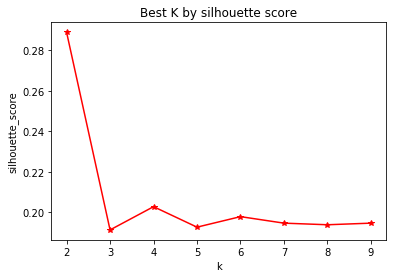

In [6]:
# K-means调参
import matplotlib.pyplot as plt
K=range(2,10)
score=[]
for k in K:
    kmeans=KMeans(n_clusters=k)
    kmeans.fit(data_input)
    score.append(silhouette_score(data_input,kmeans.labels_,metric='euclidean'))
    
plt.plot(K,score,'r*-')
plt.xlabel('k')
plt.ylabel(u'silhouette_score')
plt.title(u'Best K by silhouette score')
plt.show()

### AGG层次聚类

In [7]:
# 层次聚类
from sklearn.cluster import AgglomerativeClustering
#####这里的distance_threshold需要自己试，试了10、100、500、300
AGG = AgglomerativeClustering(distance_threshold=300,n_clusters=None,linkage = 'ward')#distance_threshold为停止合并簇类的距离
data_cluster['agg'] = AGG.fit_predict(data_input)
print(silhouette_score(data_input,data_cluster['agg']))
print(len(np.unique(data_cluster['agg'])))

0.16888166866338628
6


In [9]:
# 采用层次聚类法得到的聚类中心，作为k-means算法的初始点
center_point = data_cluster.groupby('agg').mean()[column]# 计算聚类中心点
print(center_point)
#####这里k-means的聚类数需要看上面画出的图自行判断
kmeans = KMeans(n_clusters=6,init=center_point,n_init=1)#自定义k-means初始聚类中心
data_cluster['kmeans_init_by_agg'] = kmeans.fit_predict(data_input)
print(silhouette_score(data_input,data_cluster['kmeans_init_by_agg']))
print(len(np.unique(data_cluster['kmeans_init_by_agg'])))

      assists    boosts  damageDealt     DBNOs  headshotKills     heals  \
agg                                                                       
0    0.749567  2.885449   326.027004  2.080480       0.549505  3.778638   
1    0.375729  1.952094    95.556241  0.504513       0.073915  2.890939   
2    0.207019  0.555035   180.116557  1.444023       0.395498  1.175126   
3    0.113534  0.332449    45.866701  0.179790       0.000000  0.267991   
4    1.007608  3.549534   454.272669  3.097055       1.180401  4.780492   
5    0.536168  2.439699   222.476117  1.421673       0.222750  2.480064   

     killPlace     kills  killStreaks  longestKill  ...  kill_rate  \
agg                                                 ...              
0    22.640851  2.741625     1.235820    77.942363  ...   0.409241   
1    48.018990  0.319561     0.196354     8.504835  ...   0.074779   
2    31.557767  1.524763     1.162571    23.464496  ...   0.473968   
3    71.407053  0.000000     0.000000     0.00000

### DBSCAN聚类

In [10]:
#DBSCAN聚类
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
DB = DBSCAN(eps=10,min_samples=20)#eps为密度半径
data_cluster['dbscan'] = DB.fit_predict(data_input)
print(silhouette_score(data_input,data_cluster['dbscan']))
print(len(np.unique(data_cluster['dbscan'])))

0.6486972644689906
3


DBSCAN聚类的效果最好，因此对DBSCAN方法进行深入调参

In [11]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
res = []
# 迭代不同的eps值
for eps in np.arange(7,11,1):
    # 迭代不同的min_samples值
    for min_samples in np.arange(10,20,5):
        dbscan = DBSCAN(eps = eps, min_samples = min_samples)
        # 模型拟合
        db_pre = dbscan.fit_predict(data_input)
        #统计轮廓系数
        k = silhouette_score(data_input,db_pre)
        clu_num = len(np.unique(db_pre))
        res.append({'eps':eps,'min_samples':min_samples,'score':k, 'clu_num':clu_num})
# 将迭代后的结果存储到数据框中        
df = pd.DataFrame(res)

df

,eps,min_samples,score,clu_num
0,7,10,0.485073,5
1,7,15,0.484749,4
2,8,10,0.488319,5
3,8,15,0.488402,5
4,9,10,0.489586,5
5,9,15,0.489662,5
6,10,10,0.649429,3
7,10,15,0.649436,3


在4个簇类中（表格中的簇类结果包含-1），选择轮廓系数最好的参数组合为：eps=9,min_samples=15

In [12]:
#DBSCAN聚类
# 选择上面调参得出的最佳表现的参数组合进行聚类
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
DB = DBSCAN(eps=9,min_samples=15)#eps为密度半径
data['dbscan'] = DB.fit_predict(data_input)
print(silhouette_score(data_input,data['dbscan']))
print(len(np.unique(data['dbscan'])))

0.48966204015228837
5


In [13]:
data['dbscan'].value_counts()

 0    49335
 1      489
 2      116
-1       42
 3       18
Name: dbscan, dtype: int64

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   assists                50000 non-null  float64
 1   boosts                 50000 non-null  int64  
 2   damageDealt            50000 non-null  float64
 3   DBNOs                  50000 non-null  float64
 4   headshotKills          50000 non-null  float64
 5   heals                  50000 non-null  int64  
 6   killPlace              50000 non-null  float64
 7   kills                  50000 non-null  float64
 8   killStreaks            50000 non-null  float64
 9   longestKill            50000 non-null  float64
 10  matchDuration          50000 non-null  float64
 11  revives                50000 non-null  int64  
 12  rideDistance           50000 non-null  float64
 13  roadKills              50000 non-null  float64
 14  swimDistance           50000 non-null  float64
 15  te

In [15]:
#导出数据集进行预测
data.to_csv('data_cluster_squad_V2.csv',index=False)

## 2、特征选择后聚类

In [19]:
import pandas as pd
import numpy as np
#读取数据集sampleSquad.csv
data = pd.read_csv('selectSquad_V2.csv')
data.shape

(50000, 25)

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   assists                50000 non-null  float64
 1   boosts                 50000 non-null  int64  
 2   damageDealt            50000 non-null  float64
 3   DBNOs                  50000 non-null  float64
 4   headshotKills          50000 non-null  float64
 5   heals                  50000 non-null  int64  
 6   killPlace              50000 non-null  float64
 7   kills                  50000 non-null  float64
 8   killStreaks            50000 non-null  float64
 9   longestKill            50000 non-null  float64
 10  revives                50000 non-null  int64  
 11  rideDistance           50000 non-null  float64
 12  walkDistance           50000 non-null  float64
 13  weaponsAcquired        50000 non-null  int64  
 14  totalDistance          50000 non-null  float64
 15  he

In [21]:
# 挑选出用于聚类的特征
data_cluster = data.drop(columns=['winPlacePerc'])
column = data_cluster.columns
data_cluster.head()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,kills,killStreaks,longestKill,...,totalDistance,headshot_rate,kill_rate,playersInGroup,killsPerDistance,distance_over_weapons,distance_over_heals,distance_over_kills,healthitems,skill
0,0.00,2,43.845,1.11,0.00,4,24.42,1.11,1.11,94.530,...,2916.33,0.0,0.500,4,0.000384,729.082500,729.0825,2627.324324,6,1.11
1,0.00,0,0.000,0.00,0.00,0,83.20,0.00,0.00,0.000,...,193.90,0.0,0.000,3,0.000000,48.475000,0.0000,0.000000,0,0.00
2,0.00,4,230.672,2.08,2.08,0,15.60,2.08,1.04,55.760,...,2409.00,1.0,0.500,3,0.000863,602.250000,0.0000,1158.173077,4,3.12
3,1.07,1,486.101,4.28,0.00,5,10.70,3.21,2.14,7.759,...,1927.00,0.0,0.375,3,0.001666,240.875000,385.4000,600.311526,6,2.14
4,0.00,0,0.000,0.00,0.00,0,83.93,0.00,0.00,0.000,...,157.70,0.0,0.000,1,0.000000,52.566667,0.0000,0.000000,0,0.00


In [22]:
# Z-score标准化
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
data_input = ss.fit_transform(data_cluster)
data_input

array([[-0.48876395,  0.30525328, -0.61830816, ...,  1.29031066,
         0.62732224,  0.12249579],
       [-0.48876395, -0.78528754, -0.84598281, ..., -0.53277518,
        -0.76746073, -0.73092018],
       [-0.48876395,  1.3957941 ,  0.35183148, ...,  0.27087472,
         0.16239458,  1.66787066],
       ...,
       [-0.48876395, -0.78528754,  0.01735823, ...,  1.45570871,
        -0.5349969 ,  0.83751998],
       [-0.48876395, -0.24001713,  1.0821507 , ..., -0.2232174 ,
        -0.5349969 ,  1.64480536],
       [-0.48876395, -0.78528754, -0.62046314, ..., -0.53277518,
        -0.76746073, -0.73092018]])

### DBSCAN聚类

In [23]:
#DBSCAN聚类
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
DB = DBSCAN(eps=9,min_samples=15)#eps为密度半径
data_cluster['dbscan'] = DB.fit_predict(data_input)
print(silhouette_score(data_input,data_cluster['dbscan']))
print(len(np.unique(data_cluster['dbscan'])))

0.8524841012517187
2


In [24]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
res = []
# 迭代不同的eps值
for eps in np.arange(2,4,1):
    # 迭代不同的min_samples值
    for min_samples in np.arange(5,10,1):
        dbscan = DBSCAN(eps = eps, min_samples = min_samples)
        # 模型拟合
        db_pre = dbscan.fit_predict(data_input)
        #统计轮廓系数
        k = silhouette_score(data_input,db_pre)
        clu_num = len(np.unique(db_pre))
        res.append({'eps':eps,'min_samples':min_samples,'score':k, 'clu_num':clu_num})
# 将迭代后的结果存储到数据框中        
df = pd.DataFrame(res)

df

,eps,min_samples,score,clu_num
0,2,5,0.019989,32
1,2,6,0.028969,22
2,2,7,0.058395,11
3,2,8,0.095485,10
4,2,9,0.135249,6
5,3,5,0.309773,5
6,3,6,0.422253,3
7,3,7,0.421469,3
8,3,8,0.439549,2
9,3,9,0.438079,2


In [25]:
#DBSCAN聚类
# 选择上面调参得出的最佳表现的参数组合进行聚类
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
DB = DBSCAN(eps=3,min_samples=5)#eps为密度半径
data['dbscan'] = DB.fit_predict(data_input)
print(silhouette_score(data_input,data['dbscan']))
print(len(np.unique(data['dbscan'])))

0.3097725099971472
5


In [26]:
data['dbscan'].value_counts()

 0    47707
-1     2279
 2        8
 3        4
 1        2
Name: dbscan, dtype: int64

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   assists                50000 non-null  float64
 1   boosts                 50000 non-null  int64  
 2   damageDealt            50000 non-null  float64
 3   DBNOs                  50000 non-null  float64
 4   headshotKills          50000 non-null  float64
 5   heals                  50000 non-null  int64  
 6   killPlace              50000 non-null  float64
 7   kills                  50000 non-null  float64
 8   killStreaks            50000 non-null  float64
 9   longestKill            50000 non-null  float64
 10  revives                50000 non-null  int64  
 11  rideDistance           50000 non-null  float64
 12  walkDistance           50000 non-null  float64
 13  weaponsAcquired        50000 non-null  int64  
 14  totalDistance          50000 non-null  float64
 15  he

In [28]:
#导出数据集进行预测
data.to_csv('select_cluster_squad_V2.csv',index=False)